In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
import resnet_v2
import importlib
importlib.reload(resnet_v2)
from matplotlib import pyplot  as plt
import shutil
import os
import numpy as np
from tqdm import tqdm,trange

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras.callbacks import ReduceLROnPlateau

# For the  regressor
import warnings
import os
warnings.filterwarnings("ignore") 

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import cv2
import random
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import pycocotools as pycoco
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from skimage import measure
import sklearn
import pickle

import os
import sys
from matplotlib import pyplot as plt
import random
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)
from tqdm import tqdm
import operator

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

datacsv = pd.read_csv('../../../data/processed/for_keras_generator.csv')
data_multi_fish = np.load('cleaned_reference_10.npy', allow_pickle=True)

In [2]:
data_multi_fish[322][2]
kk = [print,len]
kk[0](kk[1](data_multi_fish))
datacsv.head()

378037


,Unnamed: 0,filepath,class,size
0,0,/mnt/lts/nfs_fs02/sadow_lab/preserve/lynham/20...,Sharks,110
1,1,/mnt/lts/nfs_fs02/sadow_lab/preserve/lynham/20...,EpinephelidaeEpinephelus coioides,110
2,2,/mnt/lts/nfs_fs02/sadow_lab/preserve/lynham/20...,LutjanidaeEtelis sp.,69
3,3,/mnt/lts/nfs_fs02/sadow_lab/preserve/lynham/20...,EpinephelidaeEpinephelus chlorostigma,40
4,4,/mnt/lts/nfs_fs02/sadow_lab/preserve/lynham/20...,EpinephelidaeHyporthodus octofasciatus,100


# Load all models

In [3]:
#### Load detectron
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.975
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
MetadataCatalog.get("fishnet_val").set(thing_classes = ["fish", 'blue', 'yellow'])
#cfg.DATASETS.TEST = ("fishnet_val",)
predictor = DefaultPredictor(cfg)
val_metadata = MetadataCatalog.get("fishnet_val")
models = {"detectron":predictor}

### Apply Detectron and crop

- for each image, run it through the detectron and get predictions
- for each cropped image run it through the classifier
- for each cropped image, use that and the boxes to get a size prediction

Num images in dataset:  378037


<Figure size 432x288 with 0 Axes>

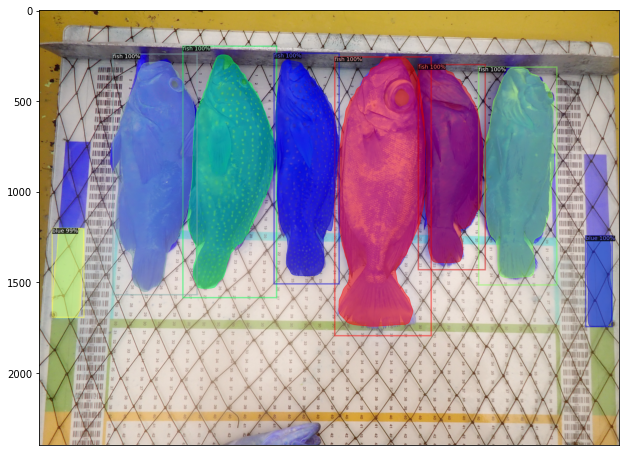

In [4]:
plt.figure()
r = 1
c = 1
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(r,c,figsize=(14,8))
plt.xticks([])
plt.xticks([])
i=0
j=0

print("Num images in dataset: ",len(data_multi_fish))
if i == r:
    i = 0
    j+=1
    
num = np.random.randint(len(data_multi_fish))
#num = 378036
im = cv2.imread(data_multi_fish[num][0])
outputs = models['detectron'](im)
v = Visualizer(im[:, :, ::-1],
                metadata=val_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels (IMAGE_BW)
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
axarr.imshow(Image.fromarray(v.get_image()[:, :, ::-1]))
i+=1
plt.show()

In [5]:
## Image variance
pp0 = np.mean(np.var(im, axis = 1), axis=1)
pp1 = np.mean(np.var(im, axis = 0), axis=1)

print(pp0.shape)
print(pp1.shape)

print(pp0.min(),pp0.max())
print(pp1.min(),pp1.max())

#now compare x and y 

#var

(3000,)
(4000,)
146.22129356250073 3238.8969062916744
1117.5916944444464 5737.346605888887


In [6]:
[k for k in data_multi_fish[num][3] if k>0]

[24, 26, 23, 24, 26, 30]

In [7]:
[k for k in data_multi_fish[num][2] if k!='']

['EpinephelidaeCephalopholis miniata',
 'EpinephelidaeCephalopholis miniata',
 'EpinephelidaeCephalopholis sonnerati',
 'EpinephelidaeCephalopholis sonnerati',
 'EpinephelidaeCephalopholis sonnerati',
 'PriacanthidaeCookeolus japonicus']

In [8]:
import functools
from os.path import isfile, join
import copy

class Helpers:
    def __init__(self):
        self.singles = True
        self.data_counts=None
        self.image_features = []
        self.data_counts = {"Boxes":0,"NoBoxes":0}
        with open('class_indices_noisy.pickle', 'rb') as handle:
            my_map = pickle.load(handle)
        self.inv_map = {v: k for k, v in my_map.items()}

    def decode_predictions(self,class_map_file):
        return class_label
        
    def get_local_image(self,number):
        im = cv2.imread(data_multi_fish[number][0])
        return im

    def get_image_size(self,number):
        size = [k for k in data_multi_fish[number][3] if k>0]
        return size
    
    def get_class_labels(self,num):
        return [k for k in data_multi_fish[num][2] if k!='']
    
    def bbox(self):
        p = mask_util.frPyObjects(self.polygons, self.height, self.width)
        p = mask_util.merge(p)
        bbox = mask_util.toBbox(p)
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        return bbox
    
    def show_image(self, num):
        img = self.get_local_image(num)
        plt.figure()
        r = 1
        c = 1
        f, axarr = plt.subplots(r,c,figsize=(16,10))
        plt.xticks([])
        i=0
        j=0
        axarr.imshow(img)
        plt.show()
        
    def show_prediction(self, num, show_img = False):
        self.curr_box = None
        try:
            img = self.get_local_image(num)
            outputs = models['detectron'](img)
            name =  datacsv["filepath"][num]

            ############### Added to cater for missing fish that only give a box #################
            classes = [y.item() for y in outputs["instances"].to("cpu").pred_classes]
            fishplace = 0
            
            for k in range(len(classes)):
                if classes[k] == 0:
                    fishplace = k
                    break
            ########################################################
            extract = np.array([np.asarray(p) for p in outputs["instances"].to("cpu").pred_masks[fishplace]])
            mask_co = np.nonzero(extract)

            self.curr_box = [np.min(mask_co[1]),np.min(mask_co[0]),np.max(mask_co[1]),np.max(mask_co[0])]

            v = Visualizer(img[:, :, ::-1],
                               metadata=MetadataCatalog.get("fishnet_val"), 
                               scale=1, 
                               instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels (IMAGE_BW)
                )
            #v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            v = v.draw_box(self.curr_box)
            img = Image.fromarray(v.get_image()[:, :, ::-1])
            hold = img.crop(self.curr_box)
            if not show_img:
                new_name = name.split('/')[-2] + '-' + name.split('/')[-1]
                try:
                    hold.save("cropped/samples/%s"%new_name)
                except Exception as kExcpt:
                    print(new_name,": %s"%kExcpt)
            else:
                plt.figure()
                r = 1
                c = 2
                #subplot(r,c) provide the no. of rows and columns
                f, axarr = plt.subplots(r,c,figsize=(16,10))
                plt.xticks([])
                plt.xticks([])
                i=0
                j=0
                axarr[0].imshow(hold)
                axarr[1].imshow(img)
                axarr[0].set_title('Prediction')
                axarr[1].set_title('Original')
                plt.show()
        except Exception as e:
            print(e)
    
    #first try at sortting top to bottom based on the corners of the bounding boxes 
    def sort_predictions(self, boxes, order):
        if len(boxes)>0:
            if order == 'TTB':
                #order top to bottom
                result = list(np.argsort([min(k[1],k[-1]) for k in boxes]))
            elif order =='BTT':
                #order bottom to top
                result = list(np.argsort([max(k[1],k[-1]) for k in boxes]))[::-1]
            else:
                #no ordering
                result = range(len(boxes))
            return result
    
    #Sorting algorithm based on varience of start and end of fish crops
    def sort_on_variance(self,box_coordinates, order=None):
        #find orientation of high variance and sort labels based on it
        if len(box_coordinates)>0:
            x_s = []
            y_s = []
            for k in box_coordinates:
                x_s.append(min(k[1],k[-1]))
                y_s.append(min(k[0],k[2]))
            #find orrientation by variance
            if  np.var(x_s)>np.var(y_s):
                #print("sort left to ryt or ryt to left")
                result = list(np.argsort([p[0] for p in box_coordinates]))
            else:
                #print("sort top to bottom or bottom up")
                result = list(np.argsort([p[2] for p in box_coordinates]))
            return result
        
        
    def new_dataset_create(self, num, show_img=False):
        img = self.get_local_image(num)
        all_data = []
        try:
            #load detectron
            dims = img.shape[:-1]
            outputs =  models['detectron'](img)
            species_predictions = []
            
            #species predictions and confidence scores and segmentation masks
            classes = outputs["instances"].to("cpu").pred_classes.numpy()
            fish = [p for p in range(len(classes)) if classes[p]==0]
            scores = outputs["instances"].to("cpu").scores.numpy()
            extract_seg = outputs["instances"].to("cpu").pred_masks.numpy()
            
            #boxes are used for length estimation of eacch side, and are normalized already
            boxes = outputs["instances"].to("cpu").pred_boxes.tensor.numpy()
            boxes = np.array([[abs(box[2] - box[0])/dims[1], abs(box[3] - box[1])/dims[0]] for box in boxes])

            try:
                mask_co = [np.nonzero(t) for t in extract_seg]
                curr_box = [[np.min(mask_co[k][1]),np.min(mask_co[k][0]),np.max(mask_co[k][1]),np.max(mask_co[k][0])] for k in fish]
                #print("in here mask_co")
            except Exception as e:
                mask_co
                curr_box=[]
            
            #now get only fish related stuff
            # first get the bounding boxes and scores, also the fish tag just to confirm its a fish
            fish_scores = [scores[l] for l in fish]
            fish_tag = [classes[l] for l in fish]
            boxes = [boxes[l] for l in fish]
            
            #3 orientations, first no sorting, then top to bottom/bottom up, or left to right 
            
            #true labels 
            name =  data_multi_fish[num][0]
            sizes = self.get_image_size(num)
            fish_species_true_labels = self.get_class_labels(num)
            
            #ttb sort
            #ttb_sort_order = self.sort_predictions(boxes, "TTB")
            
            #optimal variance sort (this is the one we use now)
            var_sort_order = self.sort_on_variance(curr_box, "TTB")
            
            #set he sort to use here so u dont change everywhere down the code
            sort_to_use = var_sort_order
            
            #see if number of fish is the same as ground truth in  each image
            num_obj = min(len(fish_tag),len(fish_species_true_labels))
            same_count = len(fish_tag)==len(fish_species_true_labels)

            if same_count:
                for ff in range(num_obj):
                    #print("here loop %s"%ff)
                    Data_holder = {}
                    Data_holder["origin_index"] = num
                    #print("here 3")
                    Data_holder["fish_sizes_VAR"] = sizes[ff]
                    Data_holder["fish_sizes_N_VAR"] = sizes[num_obj-ff-1]
                    Data_holder["fish_class_labels_VAR"] = fish_species_true_labels[ff]
                    Data_holder["fish_class_labels_N_VAR"] = fish_species_true_labels[num_obj-ff-1]
                    #print("here 4")
                    Data_holder["detected_fish_box_crops"] = curr_box[sort_to_use[ff]]
                    #print("here 5")
                    #now save this image 
                    v = Visualizer(img[:, :, ::-1],
                                   metadata=MetadataCatalog.get("fishnet_val"), 
                                   scale=1, 
                                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels (IMAGE_BW)
                    )
                    #v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
                    v = v.draw_box(curr_box[sort_to_use[ff]])
                    img_2 = Image.fromarray(v.get_image()[:, :, ::-1])
                    hold = img_2.crop(curr_box[sort_to_use[ff]])
                    if not show_img:
                        new_name = name.split('/')[-2] + '-' + name.split('/')[-1].replace('.JPG',"_"+str(ff)+".JPG")
                        Data_holder["path"] =  new_name
                        try:
                            hold.save("multi_cropped/samples/%s"%new_name)
                            all_data.append(Data_holder)
                            #print("here 6")
                        except Exception as kExcpt:
                            print(new_name,": %s"%kExcpt)
                    else:
                        plt.figure()
                        r = 1
                        c = 2
                        #subplot(r,c) provide the no. of rows and columns
                        f, axarr = plt.subplots(r,c,figsize=(16,10))
                        plt.xticks([])
                        plt.xticks([])
                        i=0
                        j=0
                        #print('display image error')
                        axarr[0].imshow(hold)
                        axarr[1].imshow(img_2)
                        axarr[0].set_title('Prediction')
                        axarr[1].set_title('Original')
                        plt.show()
        except Exception as kExcpt:
            print(num,": %s"%kExcpt)
        return all_data


In [ ]:
import pickle

num =len(data_multi_fish)
#num = 500
h1 = Helpers()
y=0
all_test = []
for k in tqdm(range(num)):
    pp = h1.new_dataset_create(k)
    if len(pp)>0:
        all_test.extend(pp)
    #save after every 20k
    if k%5000==0:
        final = pd.DataFrame(all_test)
        final.to_pickle("Fishnet_dataset_large_december.pkl")
        print("snapshot at %s iterations saved"%k)
        print("Number of fish: %s"%len(final))
        print("--------------------------------------")

  0%|          | 1/378037 [00:02<300:55:05,  2.87s/it]

snapshot at 0 iterations saved
Number of fish: 4
--------------------------------------


  1%|▏         | 5001/378037 [2:40:02<276:42:33,  2.67s/it]

snapshot at 5000 iterations saved
Number of fish: 16640
--------------------------------------


  3%|▎         | 10001/378037 [5:06:22<310:33:33,  3.04s/it]

snapshot at 10000 iterations saved
Number of fish: 32324
--------------------------------------


  4%|▎         | 13922/378037 [7:59:33<77:59:01,  1.30it/s] 

13922 : 'NoneType' object has no attribute 'shape'


  4%|▍         | 15001/378037 [8:21:35<294:17:32,  2.92s/it]

snapshot at 15000 iterations saved
Number of fish: 49744
--------------------------------------


  5%|▌         | 20001/378037 [12:00:06<341:40:42,  3.44s/it]

snapshot at 20000 iterations saved
Number of fish: 66274
--------------------------------------


  6%|▌         | 22823/378037 [14:10:33<363:32:56,  3.68s/it]

22823 : 'NoneType' object has no attribute 'shape'


  7%|▋         | 25001/378037 [15:58:15<292:26:02,  2.98s/it]

snapshot at 25000 iterations saved
Number of fish: 83675
--------------------------------------


  8%|▊         | 30001/378037 [20:00:55<338:20:26,  3.50s/it]

snapshot at 30000 iterations saved
Number of fish: 100066
--------------------------------------


  8%|▊         | 30344/378037 [20:16:18<279:21:53,  2.89s/it]

In [ ]:
final = pd.DataFrame(all_test)
final.tail(5)

## Save to pickle

In [29]:
final.to_pickle("Fishnet_dataset_large_simple.pkl")

In [30]:
len(data_multi_fish)

378037

In [ ]:
grad = 3100000
penetration = 0.1
grad*penetration